# Dependencies

In [2]:
import sys
import os
from sklearn.model_selection import StratifiedKFold

#sys.path.append(os.path.abspath(os.path.join('..', '..')))

sys.path.append(os.path.abspath('/projects/renal/srm_detection_main'))

from models.classification.classifier import cnn_classifier, xgboost, xgboost_trainer
from models.classification.cnn import PatNET
from data.dataloaders import load_classification_data, load_xgboost_data
from data.dataset import CNNDataset
from evaluation.classification.evaluate import get_cnn_predictions, get_xgb_predictions, get_cnn_val_data_from_fold_indices, load_val_xgboost_data, bootstrap_ci, evaluate_model
from utils import *

/home/local/USHERBROOKE/brai6156/.local/lib/python3.8/site-packages/matplotlib/__init__.py:186: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  a = distutils.version.LooseVersion(a)
/home/local/USHERBROOKE/brai6156/.local/lib/python3.8/site-packages/matplotlib/__init__.py:187: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  b = distutils.version.LooseVersion(b)
/usr/local/lib/python3.8/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
`np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
`np.int0` is a deprecated alias f

In [1]:
import torch

# Clear GPU cache
torch.cuda.empty_cache()

# 1. Load data

In [3]:
from sklearn.model_selection import train_test_split

def load_classification_data(task_name, clf_name):
    """
    Data Loader for classification tasks with radiomics integration.

    Parameters
    ---
    task_name: "ccRCC_vs_non_ccRCC", "grade", "subtype".
    clf_name: "cnn" or "xgboost". The augmentation rate differs for each classifier.
    """

    batch_size = 32
    batch_size = int(batch_size)

    if task_name == "ccRCC_vs_non_ccRCC":
        data, target = prepare_classification_data("ccRCC_vs_non_ccRCC")
        if clf_name == "xgb":
            pos_dataset, aug_pos_dataset, neg_dataset, aug_neg_dataset = pos_neg_aug_datasets(data, target, 2, 9)
        elif clf_name == "cnn":
            pos_dataset, aug_pos_dataset, neg_dataset, aug_neg_dataset = pos_neg_aug_datasets(data, target, 4, 14)
        else:
            raise ValueError("Enter a valid model name !!!")

        # Create DataLoader for original datasets
        loader_positives = DataLoader(pos_dataset, batch_size=batch_size)
        loader_positives_aug = DataLoader(aug_pos_dataset, batch_size=batch_size)
        loader_negatives = DataLoader(neg_dataset, batch_size=batch_size)
        loader_negatives_aug = DataLoader(aug_neg_dataset, batch_size=batch_size)

        # Load data into dictionaries
        pos_data_dict_ = get_pos_data(loader_positives)
        aug_pos_data_dict_ = get_aug_data(loader_positives_aug)
        neg_data_dict_ = get_neg_data(loader_negatives)
        aug_neg_data_dict_ = get_aug_data(loader_negatives_aug)

        # Splitting positive data into train and validation/test sets
        X_train_pos, X_val_test_pos, y_train_pos, y_val_test_pos, id_train_pos, id_val_test_pos = train_test_split(
            pos_data_dict_['img'],
            pos_data_dict_['label'],
            pos_data_dict_['Patient_ID'],
            stratify=pos_data_dict_['label'],
            test_size=0.2,
            random_state=42
        )

        # Splitting radiomics data similarly
        radiomics_train_pos, radiomics_val_test_pos = train_test_split(
            pos_data_dict_['radiomics'], test_size=0.2, random_state=42, stratify=pos_data_dict_['label']
        )
        radiomics_val_pos, radiomics_test_pos = train_test_split(
            radiomics_val_test_pos, test_size=0.5, random_state=42, stratify=y_val_test_pos
        )

        # Splitting the validation/test positive set into validation and test sets
        X_val_pos, X_test_pos, y_val_pos, y_test_pos, id_val_pos, id_test_pos = train_test_split(
            X_val_test_pos,
            y_val_test_pos,
            id_val_test_pos,
            stratify=y_val_test_pos,
            test_size=0.5,
            random_state=42
        )

        # Merge image data and radiomics features for training
        X_train_cnn = np.concatenate([X_train_pos + X_val_pos + neg_data_dict_['img'][22:], radiomics_train_pos], axis=1)
        y_train_cnn = y_train_pos + y_val_pos + neg_data_dict_['label'][22:]
        id_train_cnn = id_train_pos + id_val_pos + neg_data_dict_['Patient_ID'][22:]

        # Merge validation and test sets with radiomics and negative data
        X_test_cnn = np.concatenate([X_test_pos + neg_data_dict_['img'][:22], radiomics_test_pos], axis=1)
        y_test_cnn = y_test_pos + neg_data_dict_['label'][:22]
        id_test_cnn = id_test_pos + neg_data_dict_['Patient_ID'][:22]

        return X_train_cnn, y_train_cnn, id_train_cnn, X_test_cnn, y_test_cnn, id_test_cnn, aug_pos_data_dict_, aug_neg_data_dict_, pos_data_dict_, neg_data_dict_

    # Similar modifications for "grade" and "subtype" tasks
    # ...
    else:
        raise ValueError("Enter a valid task name !!!")


In [4]:
X_train_cnn, y_train_cnn, id_train_cnn, X_test_cnn, y_test_cnn, id_test_cnn, aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict = load_classification_data("ccRCC_vs_non_ccRCC", "cnn")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Concatenation ...
Number of Patients ready for training: 295
Negative Data:
68

Positive Data:
218


  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 218/218 [22:17<00:00,  6.13s/it] 


Total original negative samples: 68
Total augmented negative samples: 952
Total original positive samples: 218
Total augmented positive samples: 872


Processing Non ccRCC Patients:   0%|          | 0/3 [00:00<?, ?it/s]invalid value encountered in scalar divide
32it [00:00, 64.49it/s]
Processing Augmented Patients: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0.200000000000000 instead.

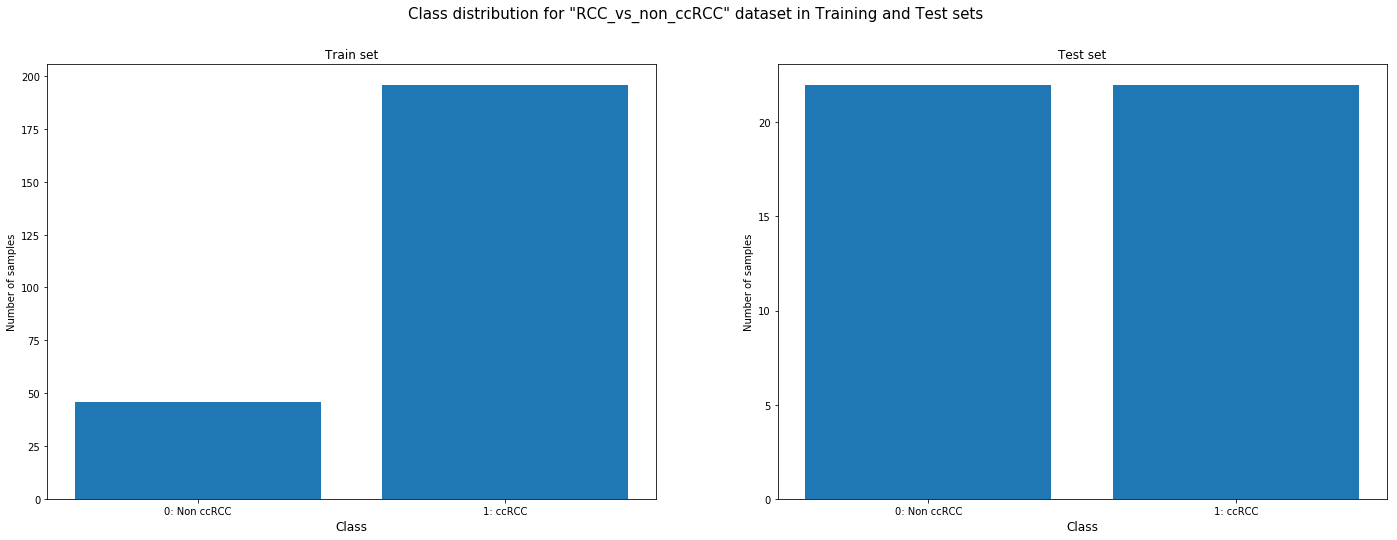

In [ ]:
# Create datasets
train_val_dataset = CNNDataset(data=X_train_cnn, data_rcc=y_train_cnn, patient_ids=id_train_cnn) 
test_dataset = CNNDataset(data=X_test_cnn, data_rcc=y_test_cnn, patient_ids=id_test_cnn)

plot_imbalance(train_val_dataset, test_dataset, "RCC_vs_non_ccRCC")

# 2. Training - CNN 

In [3]:
import torch.nn as nn
from models.classification.classifier import _train, _evaluate

def cnn_classifier(model, 
                    X_train, 
                    y_train, 
                    id_train, 
                    aug_pos_data_dict_, 
                    aug_neg_data_dict_, 
                    task_name, 
                    kfold_mode,
                    max_epochs=10, 
                    patience=3, 
                    n_splits=5, 
                    n_repeats=10,
                    lr=0.001,
                    model_folder='/projects/renal/srm_detection_main/models/weights/classification',
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                    intermediate_output=True):
    
    if kfold_mode == "repeated":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    elif kfold_mode == "stratified":
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        raise ValueError("Enter a valid kfold mode !!!")

    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    all_roc_aucs = []  # To store roc_auc values for all folds
    best_thresholds = []
    fold_indices = []

    if task_name in ["ccRCC_vs_non_ccRCC", "grade", "subtype"]:
        aug_pos_data = aug_pos_data_dict_['img']
        aug_pos_labels = aug_pos_data_dict_['label']
        aug_pos_ids = aug_pos_data_dict_['Patient_ID']

        aug_neg_data = aug_neg_data_dict_['img']
        aug_neg_labels = aug_neg_data_dict_['label']
        aug_neg_ids = aug_neg_data_dict_['Patient_ID']
    else:
        raise ValueError("Enter a valid task name !!!")

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(f"Fold {fold + 1}/{n_splits}")

        fold_indices.append((train_index, val_index))

        X_train_fold = [X_train[i] for i in train_index]
        y_train_fold = [y_train[i] for i in train_index]
        id_train_fold = [id_train[i] for i in train_index]

        X_val_fold = [X_train[i] for i in val_index]
        y_val_fold = [y_train[i] for i in val_index]
        id_val_fold = [id_train[i] for i in val_index]

        X_train_fold.extend(aug_pos_data)
        y_train_fold.extend(aug_pos_labels)
        id_train_fold.extend(aug_pos_ids)

        X_train_fold.extend(aug_neg_data)
        y_train_fold.extend(aug_neg_labels)
        id_train_fold.extend(aug_neg_ids)

        train_fold_dataset = CNNDataset(data=X_train_fold, data_rcc=y_train_fold, patient_ids=id_train_fold)
        val_fold_dataset = CNNDataset(data=X_val_fold, data_rcc=y_val_fold, patient_ids=id_val_fold)

        print(f"Batch size type: {type(32)}")  # Debugging line

        train_fold_loader = FilteredDataLoader(train_fold_dataset, batch_size=32, shuffle=True)
        val_fold_loader = FilteredDataLoader(val_fold_dataset, batch_size=8, shuffle=True)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.5)
        criterion = nn.CrossEntropyLoss()

        best_loss = float('inf')
        patience_counter = 0

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        roc_auc_fold = []  # To store roc_auc for each epoch in the current fold

        for epoch in range(max_epochs):
            train_loss, train_accuracy = _train(model, train_fold_loader, optimizer, criterion, device, intermediate_output)
            val_loss, val_accuracy, roc_auc_epoch, best_threshold = _evaluate(model, val_fold_loader, device, intermediate_output, y_val_fold)

            print(f'Epoch: {epoch+1} \t Training Loss: {train_loss:.5f} \t Training Accuracy: {train_accuracy:.5f} \t Validation Loss: {val_loss:.5f} \t Validation Accuracy: {val_accuracy:.5f}')
            print(f'Best roc/auc threshold for fold {fold + 1}: {best_threshold}')

            best_thresholds.append(best_threshold)

            scheduler.step(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model = model
                torch.save(model.state_dict(), os.path.join(model_folder, f'{task_name}/best_{task_name}_clf_fold_{fold + 1}.pth'))
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            roc_auc_fold.append(roc_auc_epoch)  # Store roc_auc for the current epoch

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
        all_roc_aucs.append(roc_auc_fold)  # Store roc_auc for the current fold

    return all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies, best_thresholds, all_roc_aucs, fold_indices, best_model


In [4]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = PatNET().to(device)

all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies, best_thresholds, roc_auc, fold_indices, best_cnn_model = cnn_classifier(clf,
               X_train_cnn,
               y_train_cnn,
               id_train_cnn,
               aug_pos_data_dict,
               aug_neg_data_dict,
               "ccRCC_vs_non_ccRCC",
               "stratified",
               max_epochs=15, 
               patience=3,
               n_splits=5)

Fold 1/5
Batch size type: <class 'int'>
Epoch: 1 	 Training Loss: 0.70803 	 Training Accuracy: 0.52206 	 Validation Loss: 0.68907 	 Validation Accuracy: 0.81633
Best roc/auc threshold for fold 1: 0.5158701539039612
Epoch: 2 	 Training Loss: 0.68959 	 Training Accuracy: 0.52851 	 Validation Loss: 0.69237 	 Validation Accuracy: 0.81633
Best roc/auc threshold for fold 1: 0.5228362083435059
Epoch: 3 	 Training Loss: 0.68772 	 Training Accuracy: 0.54586 	 Validation Loss: 0.68546 	 Validation Accuracy: 0.81633
Best roc/auc threshold for fold 1: 0.5326324105262756
Epoch: 4 	 Training Loss: 0.83190 	 Training Accuracy: 0.54289 	 Validation Loss: 0.67368 	 Validation Accuracy: 0.83673
Best roc/auc threshold for fold 1: 0.5390048623085022
Epoch: 5 	 Training Loss: 0.68119 	 Training Accuracy: 0.53594 	 Validation Loss: 0.67781 	 Validation Accuracy: 0.81633
Best roc/auc threshold for fold 1: 0.5326094627380371
Epoch: 6 	 Training Loss: 0.67006 	 Training Accuracy: 0.54487 	 Validation Loss: 0.6

In [5]:
roc_auc

[[0.4722222222222222,
  0.5138888888888888,
  0.5694444444444444,
  0.6111111111111112,
  0.7555555555555556,
  0.6666666666666666,
  0.5888888888888889,
  0.523611111111111],
 [0.517948717948718,
  0.6769230769230768,
  0.6538461538461539,
  0.6820512820512821,
  0.6666666666666667],
 [0.6951566951566952,
  0.7207977207977209,
  0.7777777777777778,
  0.7264957264957266],
 [0.7763532763532763,
  0.8461538461538461,
  0.8433048433048433,
  0.849002849002849,
  0.8575498575498576,
  0.7834757834757835,
  0.754985754985755],
 [0.9430199430199431,
  0.9344729344729346,
  0.9173789173789174,
  0.9031339031339032]]

In [7]:
'''low_ic, up_ic = bootstrap_ci(roc_auc)
print(f"(AUC) mean ± std : {np.mean(roc_auc):.3f} ± {np.std(roc_auc):.3f} ({low_ic:.2f},{up_ic:.2f})")'''

import numpy as np
from sklearn.utils import resample

# Define the bootstrap_ci function
def bootstrap_ci(values, n_bootstrap=1000, confidence_level=0.95):
    """Calculate the bootstrap confidence interval."""
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample = resample(values, replace=True, n_samples=len(values))
        bootstrap_samples.append(np.mean(sample))  # Calculate mean for each sample

    lower = np.percentile(bootstrap_samples, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(bootstrap_samples, (1 + confidence_level) / 2 * 100)
    return lower, upper

# List to store confidence intervals for each fold
fold_ci = []

# Iterate through each fold's roc_auc values
for i, fold_roc_auc in enumerate(roc_auc):
    # Calculate mean and std for the current fold
    mean_auc = np.mean(fold_roc_auc)
    std_auc = np.std(fold_roc_auc)
    
    # Apply bootstrap_ci to the current fold's ROC AUC values
    low_ic, up_ic = bootstrap_ci(fold_roc_auc)
    
    # Print the result in the desired format
    print(f"Fold {i+1}: (AUC) mean ± std : {mean_auc:.3f} ± {std_auc:.3f} ({low_ic:.2f}, {up_ic:.2f})")



Fold 1: (AUC) mean ± std : 0.588 ± 0.085 (0.53, 0.66)
Fold 2: (AUC) mean ± std : 0.639 ± 0.062 (0.58, 0.68)
Fold 3: (AUC) mean ± std : 0.730 ± 0.030 (0.70, 0.76)
Fold 4: (AUC) mean ± std : 0.816 ± 0.039 (0.79, 0.84)
Fold 5: (AUC) mean ± std : 0.925 ± 0.015 (0.91, 0.94)


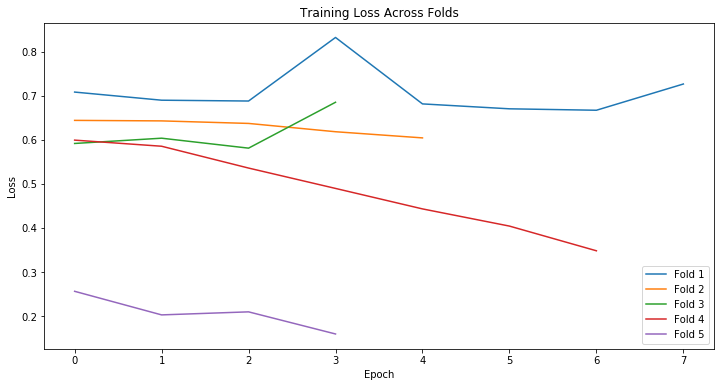

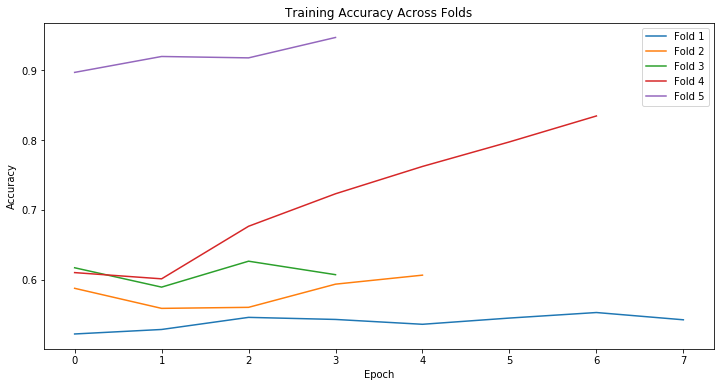

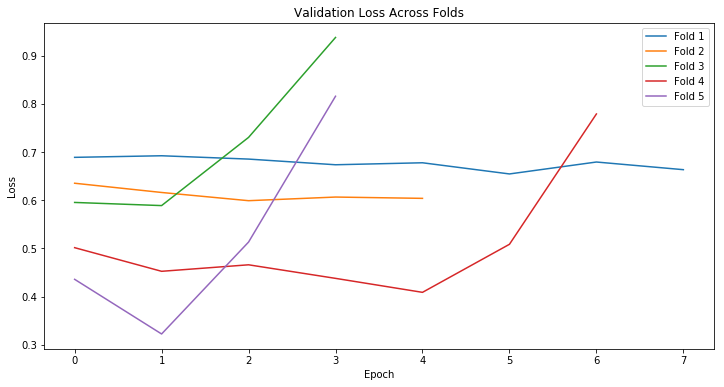

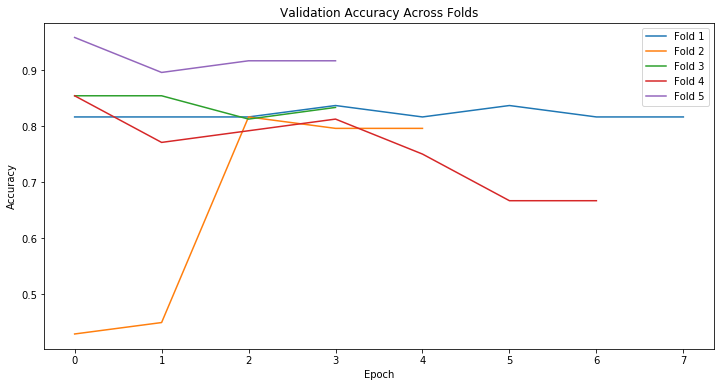

In [6]:
plot_metrics_folds(all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, num_folds=5)

# 3. Training - XGBOOST (On radiomics)

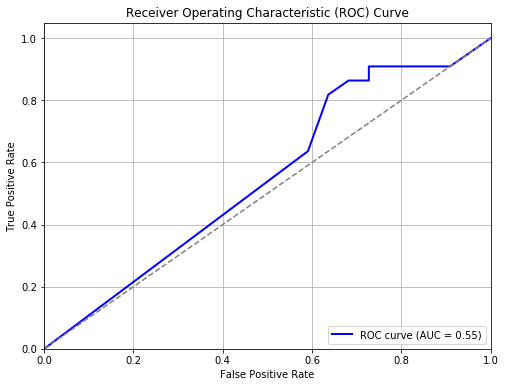

<Figure size 576x432 with 0 Axes>

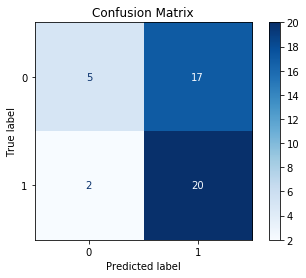

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.1, 'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}, 'accuracy': 0.56818181

[15:49:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


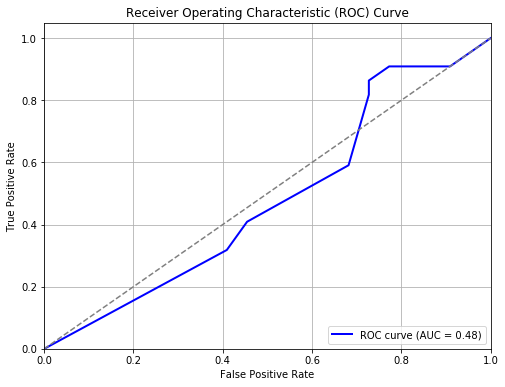

<Figure size 576x432 with 0 Axes>

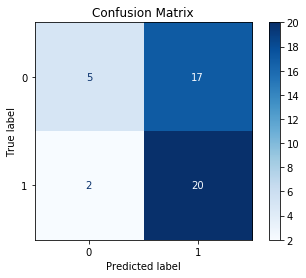

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy

[16:29:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


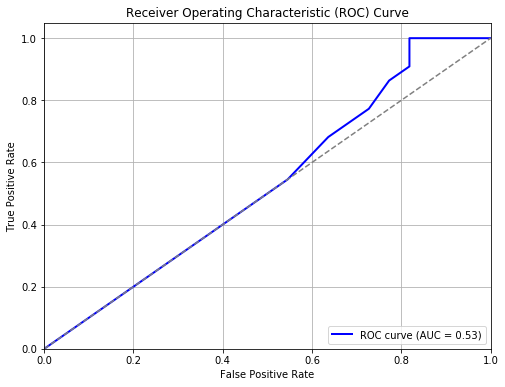

<Figure size 576x432 with 0 Axes>

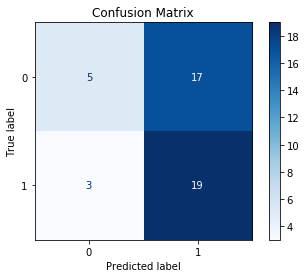

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy': 0.5454545454545454, 'prec

[18:02:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


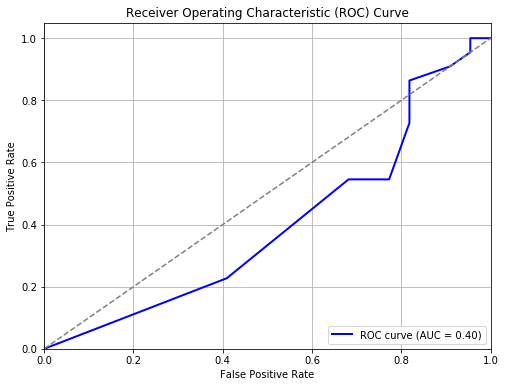

<Figure size 576x432 with 0 Axes>

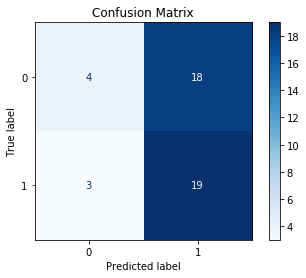

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.9999999999999999}, 'accuracy

[19:34:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


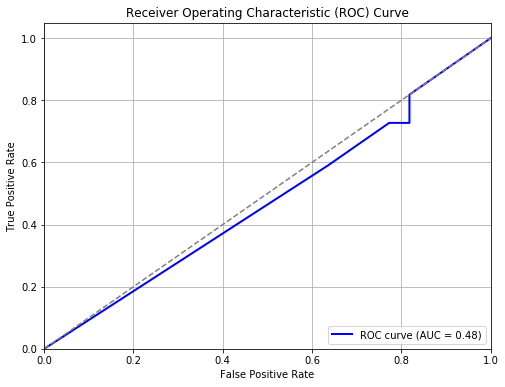

<Figure size 576x432 with 0 Axes>

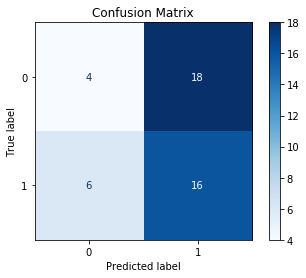

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9999999999999999, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'selected_features': array([ True,  True,  True]), 'best_params': {'colsample_bytree': 0.9999999999999999, 'gamma': 0.2, 'learning_rate': 0.25, 'max_depth': 11, 'n_estimators': 200, 'subsample': 0.7999999999999999}, 'accu

[21:06:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [10]:
all_xgb_models = xgboost_trainer("ccRCC_vs_non_ccRCC", "/projects/renal/srm_detection_main/models/weights/classification/ccRCC_vs_non_ccRCC/xgboost", aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict, num_pos=382, num_neg=532)

In [8]:
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, X_train_xgb_aug, y_train_xgb_aug = load_xgboost_data("ccRCC_vs_non_ccRCC", aug_pos_data_dict, aug_neg_data_dict, pos_data_dict, neg_data_dict, num_pos=382, num_neg=532)

In [ ]:
# test with xgb model 1
xgb_probs_1 = get_xgb_predictions(all_xgb_models[1], X_test_xgb)
# test with xgb model 6
xgb_probs_6 = get_xgb_predictions(all_xgb_models[6], X_test_xgb)

In [10]:
# or load best xgboost model
import xgboost as xgb

xgb_model_file = "/projects/renal/srm-detection-main/models/weights/classification/ccRCC_vs_non_ccRCC/final/xgboost/xgboost_model_attempt_9_more_aug_600.bin"
best_xgb_model = xgb.XGBClassifier()
best_xgb_model.load_model(xgb_model_file)

xgb_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)

# 4. Evaluation

### I. XGBOOST

In [26]:
import pandas as pd

# Stratified K-Fold on the test set
skf = StratifiedKFold(n_splits=5)
test_results = []

roc_aucs = []
sensitivities = []
specificities = []

for fold, (train_index, test_index) in enumerate(skf.split(X_test_xgb, y_test_xgb)):
    X_true = np.array([X_test_xgb[i] for i in test_index])
    y_true = np.array([y_test_xgb[i] for i in test_index])
    y_probs = get_xgb_predictions(best_xgb_model, X_true)
    y_preds = (y_probs > 0.5).astype(int)

    metrics_report = evaluate_model(y_true, y_preds, y_probs)
    roc_aucs.append(metrics_report['ROC AUC'])
    sensitivities.append(metrics_report['Sensitivity'])
    specificities.append(metrics_report['Specificity'])
    
    # Append results to the list
    test_results.append({
        'Fold': fold + 1,
        'ROC AUC': metrics_report['ROC AUC'],
        'Sensitivity': metrics_report['Sensitivity'],
        'Specificity': metrics_report['Specificity']
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(test_results)

# Calculate bootstrap confidence intervals
roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
specificity_ci_L, specificity_ci_U  = bootstrap_ci(specificities)

# Display the per-fold results
print("Per-Fold Results:")
print(df_results)

# Calculate and display the summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['ROC AUC', 'Sensitivity', 'Specificity'],
    'Mean ± Std': [
        f"{np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}",
        f"{np.mean(sensitivities):.3f} ± {np.std(sensitivities):.3f}",
        f"{np.mean(specificities):.3f} ± {np.std(specificities):.3f}"
    ],
    '95% CI': [
        f"{roc_auc_ci_L:.3f} - {roc_auc_ci_U:.3f}",
        f"{sensitivity_ci_L:.3f} - {sensitivity_ci_U:.3f}",
        f"{specificity_ci_L:.3f} - {specificity_ci_U:.3f}"
    ]
})

print("\nSummary Statistics:")
print(summary_stats)


Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1     0.75         0.75         0.80
1     2     0.70         0.50         0.80
2     3     0.90         0.80         0.75
3     4     0.65         0.60         0.75
4     5     1.00         0.75         1.00

Summary Statistics:
        Metric     Mean ± Std         95% CI
0      ROC AUC  0.800 ± 0.130  0.650 - 1.000
1  Sensitivity  0.680 ± 0.112  0.500 - 0.800
2  Specificity  0.820 ± 0.093  0.750 - 1.000


### II. CNN

In [35]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_cnn_model = PatNET().to(device)
# Load the state dict on CPU of the 43th CNN Model (Best one)
best_cnn_model.load_state_dict(torch.load('/projects/renal/srm-detection-main/models/weights/classification/ccRCC_vs_non_ccRCC/final/augmented_2000/best_ccRCC_vs_non_ccRCC_clf_fold_10.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
import numpy as np
import pandas as pd

# Stratified K-Fold on the test set
skf = StratifiedKFold(n_splits=5)
test_results = []

roc_aucs = []
sensitivities = []
specificities = []

for fold, (train_index, test_index) in enumerate(skf.split(X_test_cnn, y_test_cnn)):
    X_true = [X_test_cnn[i] for i in test_index]  # Keep as a list
    y_true = np.array([y_test_cnn[i] for i in test_index])

    y_probs = get_cnn_predictions(best_cnn_model, X_true, device)
    
    # Ensure y_probs is a NumPy array
    y_probs = np.array(y_probs)
    
    # Perform the comparison to generate binary predictions
    y_preds = (y_probs > 0.5).astype(int)
    
    metrics_report = evaluate_model(y_true, y_preds, y_probs)

    roc_aucs.append(metrics_report['ROC AUC'])
    sensitivities.append(metrics_report['Sensitivity'])
    specificities.append(metrics_report['Specificity'])

    # Append results to the list
    test_results.append({
        'Fold': fold + 1,
        'ROC AUC': metrics_report['ROC AUC'],
        'Sensitivity': metrics_report['Sensitivity'],
        'Specificity': metrics_report['Specificity']
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(test_results)

# Calculate bootstrap confidence intervals
roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
specificity_ci_L, specificity_ci_U  = bootstrap_ci(specificities)

# Display the per-fold results
print("Per-Fold Results:")
print(df_results)


# Calculate means and standard deviations
roc_auc_mean = np.mean(roc_aucs)
roc_auc_std = np.std(roc_aucs)
sensitivity_mean = np.mean(sensitivities)
sensitivity_std = np.std(sensitivities)
specificity_mean = np.mean(specificities)
specificity_std = np.std(specificities)

# Calculate bootstrap confidence intervals
roc_auc_ci_L, roc_auc_ci_U = bootstrap_ci(roc_aucs)
sensitivity_ci_L, sensitivity_ci_U = bootstrap_ci(sensitivities)
specificity_ci_L, specificity_ci_U = bootstrap_ci(specificities)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['ROC AUC', 'Sensitivity', 'Specificity'],
    'Mean ± Std': [
        f"{roc_auc_mean:.3f} ± {roc_auc_std:.3f}",
        f"{sensitivity_mean:.3f} ± {sensitivity_std:.3f}",
        f"{specificity_mean:.3f} ± {specificity_std:.3f}"
    ],
    '95% CI': [
        f"{roc_auc_ci_L:.3f} - {roc_auc_ci_U:.3f}",
        f"{sensitivity_ci_L:.3f} - {sensitivity_ci_U:.3f}",
        f"{specificity_ci_L:.3f} - {specificity_ci_U:.3f}"
    ]
})

print()
print(summary_df)


Per-Fold Results:
   Fold  ROC AUC  Sensitivity  Specificity
0     1     0.90         0.60         1.00
1     2     0.70         0.80         0.75
2     3     0.80         0.75         0.80
3     4     0.90         1.00         0.60
4     5     0.75         0.50         0.75

        Metric     Mean ± Std         95% CI
0      ROC AUC  0.810 ± 0.080  0.700 - 0.900
1  Sensitivity  0.730 ± 0.172  0.500 - 1.000
2  Specificity  0.780 ± 0.129  0.600 - 1.000


# Ensembling

### Approach 1: Stacking CNN + XGBOOST Predictions

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.


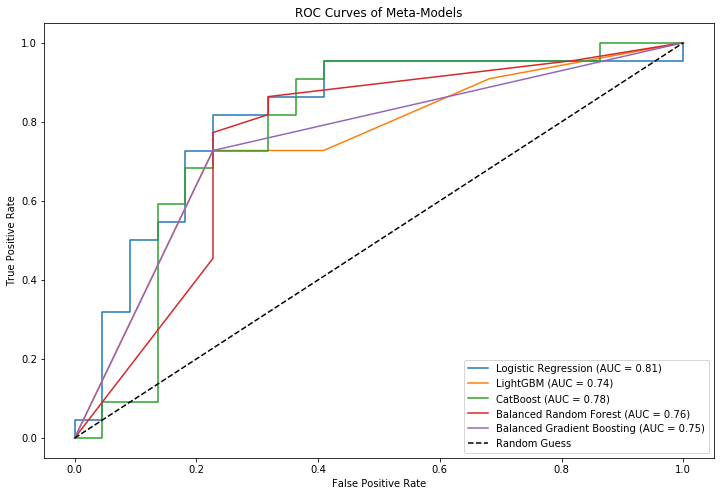

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.78      0.82      0.80        22

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44



LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.76      0.73      0.74        22

    accuracy                           0.75        44
   macro avg       0.75      0.75      0.75        44
weighted avg       0.75      0.75      0.75        44



CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.76      0.73      0.74        22

    accuracy                           0.75        44
   macro avg     

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

# Define meta-models
meta_models = {
    'Logistic Regression': LogisticRegression(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(learning_rate=0.1, depth=6, iterations=100, loss_function='Logloss', silent=True),
    'Balanced Random Forest': BalancedRandomForestClassifier(),
    'Balanced Gradient Boosting': BalancedBaggingClassifier(estimator=GradientBoostingClassifier(), sampling_strategy='auto'),
}

# Train meta-models and generate predictions
roc_curves = {}
classification_reports = {}

# Generate predictions on the training data
cnn_train_probs = get_cnn_predictions(best_cnn_model, X_train_cnn, device)
xgb_train_probs = get_xgb_predictions(best_xgb_model, X_train_xgb)

# Stack training predictions
stacked_X_train = np.vstack((cnn_train_probs, xgb_train_probs)).T


for name, model in meta_models.items():
    # Train the meta-model
    model.fit(stacked_X_train, y_train_cnn)
    
    # Generate predictions on the test data
    cnn_test_probs = get_cnn_predictions(best_cnn_model, X_test_cnn, device)
    xgb_test_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)
    # Stack training predictions
    stacked_X_test = np.vstack((cnn_test_probs, xgb_test_probs)).T
    
    # Make final predictions with the meta-model
    test_probs = model.predict_proba(stacked_X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_cnn, test_probs)
    roc_auc = roc_auc_score(y_test_cnn, test_probs)
    
    # Store ROC curve data
    roc_curves[name] = (fpr, tpr, roc_auc)
    
    # Generate classification report
    final_predictions = model.predict(stacked_X_test)
    classification_reports[name] = classification_report(y_test_cnn, final_predictions)

# Plot ROC Curves
plt.figure(figsize=(12, 8))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Meta-Models')
plt.legend()
plt.show()

# Print Classification Reports
for name, report in classification_reports.items():
    print(f"{name} Classification Report:")
    print(report)
    print("\n")


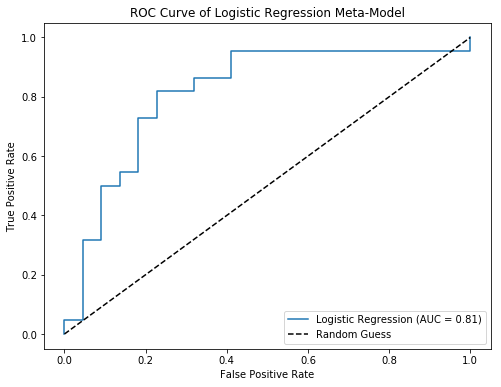

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.78      0.82      0.80        22

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44



In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd



# Generate predictions on the training data
cnn_train_probs = get_cnn_predictions(best_cnn_model, X_train_cnn, device)
xgb_train_probs = get_xgb_predictions(best_xgb_model, X_train_xgb)

# Stack training predictions
stacked_X_train = np.vstack((cnn_train_probs, xgb_train_probs)).T

# Train the Logistic Regression meta-model
logistic_model = LogisticRegression()
logistic_model.fit(stacked_X_train, y_train_cnn)

# Generate predictions on the test data
cnn_test_probs = get_cnn_predictions(best_cnn_model, X_test_cnn, device)
xgb_test_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)
stacked_X_test = np.vstack((cnn_test_probs, xgb_test_probs)).T

# Make final predictions with the Logistic Regression model
test_probs = logistic_model.predict_proba(stacked_X_test)[:, 1]
final_predictions = logistic_model.predict(stacked_X_test)

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_cnn, test_probs)
roc_auc = roc_auc_score(y_test_cnn, test_probs)

# Classification Report
classification_report_text = classification_report(y_test_cnn, final_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression Meta-Model')
plt.legend()
plt.show()

# Print Classification Report
print("Logistic Regression Classification Report:")
print(classification_report_text)


Metrics DataFrame:
        Metric     Value
0  Specificity  0.772727
1  Sensitivity  0.818182
2          AUC  0.814050


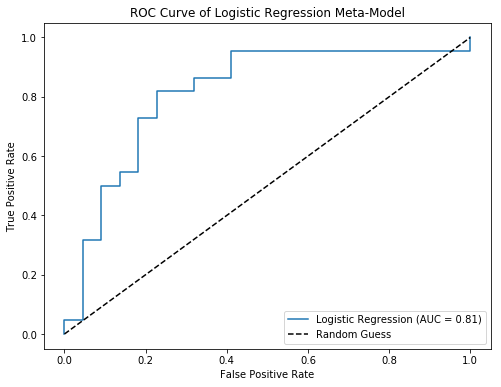

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.78      0.82      0.80        22

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44



In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Function to calculate specificity and sensitivity from confusion matrix
def calculate_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    return specificity, sensitivity

# Generate predictions on the training data
cnn_train_probs = get_cnn_predictions(best_cnn_model, X_train_cnn, device)
xgb_train_probs = get_xgb_predictions(best_xgb_model, X_train_xgb)

# Stack training predictions
stacked_X_train = np.vstack((cnn_train_probs, xgb_train_probs)).T

# Train the Logistic Regression meta-model
logistic_model = LogisticRegression()
logistic_model.fit(stacked_X_train, y_train_cnn)

# Generate predictions on the test data
cnn_test_probs = get_cnn_predictions(best_cnn_model, X_test_cnn, device)
xgb_test_probs = get_xgb_predictions(best_xgb_model, X_test_xgb)
stacked_X_test = np.vstack((cnn_test_probs, xgb_test_probs)).T

# Make final predictions with the Logistic Regression model
test_probs = logistic_model.predict_proba(stacked_X_test)[:, 1]
final_predictions = logistic_model.predict(stacked_X_test)

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_cnn, test_probs)
roc_auc = roc_auc_score(y_test_cnn, test_probs)

# Classification Report
classification_report_text = classification_report(y_test_cnn, final_predictions)

# Calculate specificity and sensitivity
specificity, sensitivity = calculate_specificity_sensitivity(y_test_cnn, final_predictions)

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Specificity', 'Sensitivity', 'AUC'],
    'Value': [specificity, sensitivity, roc_auc]
})

# Print the DataFrame
print("Metrics DataFrame:")
print(metrics_df)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression Meta-Model')
plt.legend()
plt.show()

# Print Classification Report
print("Logistic Regression Classification Report:")
print(classification_report_text)


### Approach 2: XGBOOST trained on CNN Features + Radiomics

CNN-Based Feature Extraction: CNNs is used to extract deep features from medical images. These features are then fed into traditional machine learning models (e.g., XGBoost, random forests).

In [ ]:
train_index, val_index = fold_indices[2] # select a random fold set for training
train_intermediate_outputs, test_intermediate_outputs, train_loader, test_loader, y_train = get_intermediate_cnn_features(X_train_cnn, 
                                                                                                                                y_train_cnn,
                                                                                                                                id_train_cnn,
                                                                                                                                aug_pos_data_dict,
                                                                                                                                aug_neg_data_dict,
                                                                                                                                train_index, 
                                                                                                                                val_index, 
                                                                                                                                best_cnn_model, 
                                                                                                                                device)

In [ ]:
train_intermediate_outputs_df = pd.DataFrame(train_intermediate_outputs.cpu().numpy())
train_intermediate_outputs_df.head()

In [ ]:
test_intermediate_outputs_df = pd.DataFrame(test_intermediate_outputs.cpu().numpy())
test_intermediate_outputs_df.head()

In [ ]:
X_train = stack_deep_radiomics_features(train_loader, train_intermediate_outputs)
X_test = stack_deep_radiomics_features(test_loader, test_intermediate_outputs)

xgb_cnn_rads_model = xgboost(X_train, X_test, y_train, y_test_cnn)
xgb_cnn_rads_model

### Approach 3: XGBOOST Trained on CNN Features

In [42]:
xgb_cnn_features_model = xgboost(X_train['cnn_features'], X_test['cnn_features'], y_train, y_test_cnn)
xgb_cnn_features_model

NameError: name 'X_train' is not defined

# Model Calibration